In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,  Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from matplotlib.pyplot import imshow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Check the images

In [4]:



base_dir = r"/content/drive/MyDrive/Nigerian_attaires/data/training" 

#this list contains the name of the cloths
lists = ['ankara','atiku','lace','aso oke']

cloth_dict = {}

files_dict = {}


#This function is to check the images in the trainnig directory
def check_image(base,cloth_path,files_path, img_list):
  for v in lists:
    g = v + "_dir" 
    cloth_path[g] = os.path.join(base, v)
    print("total training " + v + " images:", len(os.listdir(cloth_path[g])))
    f = v + "_files"
    files_path[f] = os.listdir(cloth_path[g])
    print(files_path[f][:10],"\n")
    # # print(f[:10])

check_image(base_dir,cloth_dict,files_dict, lists)



total training ankara images: 42
['38.jpg', '19.jpg', '34.jpg', '13.jpg', '46.jpg', '6.jpg', '28.jpg', '7.jpg', '1.jpg', '48.jpg'] 

total training atiku images: 41
['32.jpg', '31.jpg', '16.jpg', '13.jpg', '42.jpg', '38.jpg', '3.jpg', '24.jpg', '40.jpg', '14.jpg'] 

total training lace images: 41
['1.jpg', '17.jpg', '37.jpg', '48.jpg', '14.jpg', '41.jpg', '13.jpg', '23.jpg', '28.jpg', '42.jpg'] 

total training aso oke images: 42
['27.jpg', '7.jpg', '29.jpg', '22.jpg', '6.jpg', '21.jpg', '1.jpg', '40.jpg', '28.jpg', '49.jpg'] 



ankara   (237, 213, 3)


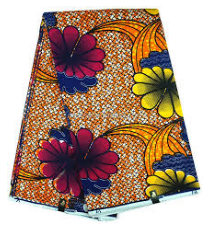

ankara   (225, 225, 3)


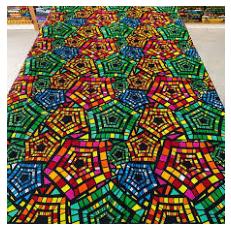

atiku   (225, 225, 3)


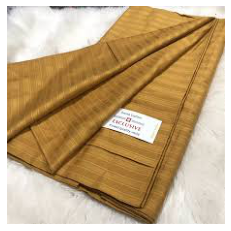

atiku   (225, 225, 3)


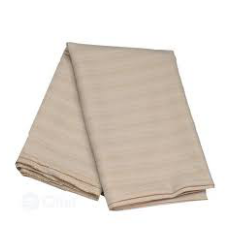

lace   (232, 217, 3)


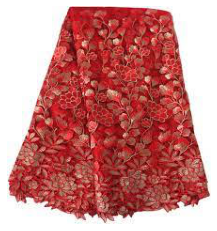

lace   (269, 187, 3)


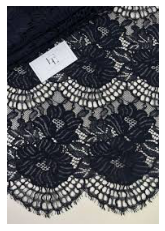

aso oke   (225, 225, 3)


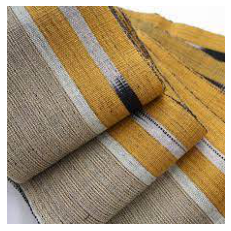

aso oke   (221, 228, 3)


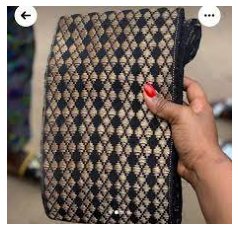

In [5]:




def show_image(cloth, file, cloth_list):
  pic_index = 2
  for i in cloth_list:
    next = [os.path.join(cloth[i + '_dir'], fname) for fname in file[i + '_files'][pic_index-2:pic_index]]
    for _ in next:
      img = mpimg.imread(_)
      print(i," ", img.shape)
      # print(img.shape)
      plt.imshow(img)
      plt.axis('Off')
      plt.show()

      
show_image(cloth_dict, files_dict, lists)

  

#Loading the data

In [6]:
TRAINING_DIR =  r"/content/drive/MyDrive/Nigerian_attaires/data/training" 
VALIDATION_DIR = r"/content/drive/MyDrive/Nigerian_attaires/data/validation"


def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  #Creates the training and validation data generators



  # Instantiate the ImageDataGenerator class 
  train_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest'
                                     )

 
 
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=5,
                                                      class_mode='categorical',
                                                      target_size=(150,150))

  # Instantiate the ImageDataGenerator class 
  validation_datagen = ImageDataGenerator(rescale=1/255)

  
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=5,
                                                                class_mode='categorical',
                                                                target_size=(150,150))
  
  return train_generator, validation_generator


In [7]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 166 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [8]:
#We are going to store the labels in a text file

label = '\n'.join(sorted(train_generator.class_indices.keys()))
print(label)

with open('/content/drive/MyDrive/Nigerian_attaires/labels.txt', 'w') as f:
  f.write(label)

ankara
aso oke
atiku
lace


#Model Architecture

###Function definitions

In [9]:
IMG_SHAPE = (150,150,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
#the first two layers are the top layers and there are responsible for the classification of the model

nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

print("Number of layers in the base model: ", nb_layers)

Conv_1_bn
out_relu
Number of layers in the base model:  154


In [11]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    training=False

Number of layers in the base model:  154


In [12]:

def alpaca_model():
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=(150,150,3)) 


    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(inputs) 
    # use global avg pooling to summarize the info in each channel
    # x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x) 
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    x = tf.keras.layers.Dense(128)(x)
    
    # create the output
    outputs = tf.keras.layers.Dense(4,activation='softmax')(x)
    # create the model
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [13]:
# Train the model
model = alpaca_model()


base_learning_rate = 0.001

# Define a BinaryCrossentropy loss function. 
loss_function=tf.keras.losses.CategoricalCrossentropy()
# Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=0.1 * base_learning_rate)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 128)               65664 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy")

history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
34/34 [==============================] - 44s 1s/step - loss: 1.2531 - accuracy: 0.4518 - val_loss: 0.7296 - val_accuracy: 0.6562
Epoch 2/50
34/34 [==============================] - 5s 156ms/step - loss: 0.8216 - accuracy: 0.6687 - val_loss: 1.0177 - val_accuracy: 0.6250
Epoch 3/50
34/34 [==============================] - 4s 123ms/step - loss: 0.5924 - accuracy: 0.7590 - val_loss: 0.9276 - val_accuracy: 0.6250
Epoch 4/50
34/34 [==============================] - 4s 122ms/step - loss: 0.5863 - accuracy: 0.7952 - val_loss: 0.7440 - val_accuracy: 0.7500
Epoch 5/50
34/34 [==============================] - 4s 126ms/step - loss: 0.6738 - accuracy: 0.7289 - val_loss: 0.3684 - val_accuracy: 0.8125
Epoch 6/50
34/34 [==============================] - 6s 175ms/step - loss: 0.4456 - accuracy: 0.8072 - val_loss: 0.3340 - val_accuracy: 0.8438
Epoch 7/50
34/34 [==============================] - 4s 122ms/step - loss: 0.4755 - accuracy: 0.8313 - val_loss: 0.3434 - val_accuracy: 0.9062
Epoch 8/

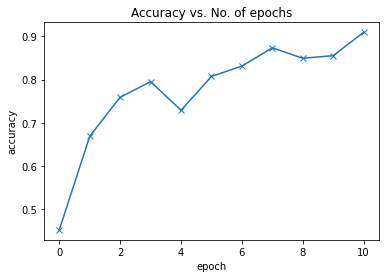

In [15]:
# to plot the accuracies
def plot_accuracies(history):
    accuracies = [x for x in history.history['accuracy']]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

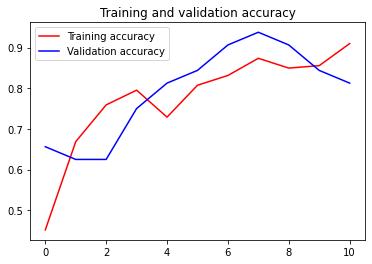

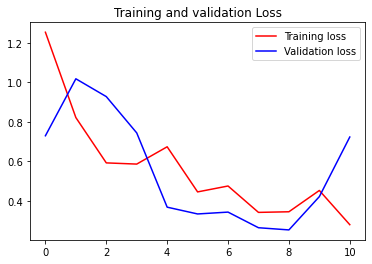

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [18]:
#directory that contains the validation datasets
base_dir = "/content/drive/MyDrive/Nigerian_attaires/data/validation"

def prediction(dir):
  img_path = dir
  img = image.load_img(img_path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.0
  print('Input image shape:', x.shape)
  imshow(img)
  prediction = model.predict(x)
  g = np.argmax(prediction)
  if g == 1:
    print('Class : Ankara')
  elif(g == 2):
    print('Class : Aso oke')
  elif(g == 2):
    print('Class : Atiku')
  else:
    print('Class : Lace')



Input image shape: (1, 150, 150, 3)
1/1 [==============================] - 0s 34ms/step
Class : Ankara


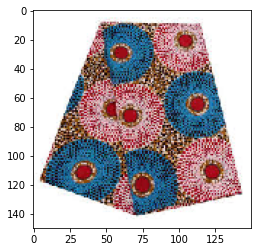

In [24]:
ank_dir = os.path.join(base_dir, 'ankara/11.jpg')


prediction(ank_dir)

Input image shape: (1, 150, 150, 3)
1/1 [==============================] - 0s 45ms/step
Class : Ankara


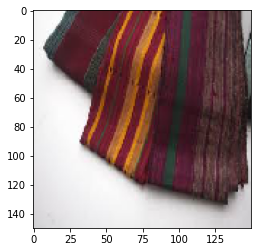

In [21]:
aso_oke_dir = os.path.join(base_dir, 'aso oke/13.jpg')


prediction(aso_oke_dir)

Input image shape: (1, 150, 150, 3)
1/1 [==============================] - 0s 26ms/step
Class : Aso oke


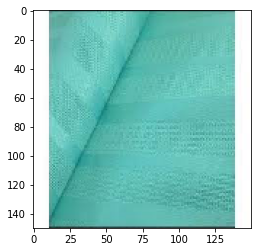

In [25]:
atiku_dir = os.path.join(base_dir, 'atiku/23.jpg')


prediction(atiku_dir)

Input image shape: (1, 150, 150, 3)
1/1 [==============================] - 0s 26ms/step
Class : Lace


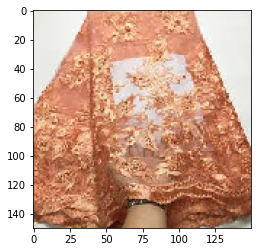

In [23]:
lace_dir = os.path.join(base_dir, 'lace/19.jpg')


prediction(lace_dir)

In [ ]:

model.save("/content/drive/MyDrive/Nigerian_attaires/attire_model")

In [ ]:
attire_model = tf.keras.models.load_model('/content/drive/MyDrive/Nigerian_attaires/attire_model')

##Convert the model to tensoflowlite version

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(attire_model)
tflite_model = converter.convert()


with open('/content/drive/MyDrive/Nigerian_attaires/attire_model/tf_attire_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
#to download the files to our local system
from google.colab import files

files.download('/content/drive/MyDrive/Nigerian_attaires/attire_model/tf_attire_model.tflite')
files.download('/content/drive/MyDrive/Nigerian_attaires/labels.txt')